# Machine Learning: Ridge Regression vs. LASSO

#Note: For all of the questions in this notebook are intended to make you think --- don't worry too much about getting exactly the right answer.

## Method 1: Ridge Regression

Ridge regression is a regression technique that is quite similar to unadorned least squares linear regression: simply adding an $\ell_2$ **penalty** on the parameters $w$ to the objective function for linear regression yields the objective function for ridge regression.

Our goal is to find an assignment to $w$ that minimizes the function

$$f(w) = \|Xw - Y\|_2^2 + \lambda \|w\|_2^2,$$

where $\lambda$ is a hyperparameter and, as usual, $X$ is the training data and $Y$ the observations. In practice, we tune $\lambda$ until we find a model that generalizes well to the test data.

Ridge regression is an example of a **shrinkage method**: compared to least squares, it shrinks the parameter estimates in the hopes of **reducing variance, improving prediction accuracy, and aiding interpetation**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyval
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures

In [2]:
num_samples = 100

In [3]:
def lift_data(x, degree):
    return np.vstack([x**i for i in np.arange(degree + 1)]).T

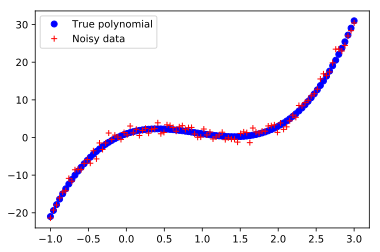

In [4]:
x = np.linspace(-1, 3, num_samples)

# We generate data from a 3rd degree polynomial
coef = [1,7,-11,4]; # 4x^3 -11 x^2 +7 x + 1
true_y = polyval(x, coef)

# The data we actually use to fit the model will be a noisy estimate of the true, underlying polynomial
y = true_y + np.random.normal(0, 1, num_samples)

plt.plot(x,true_y,'bo')
plt.plot(x,y,'r+')

plt.legend(['True polynomial', 'Noisy data'])
plt.show()

In [5]:
def ridge(X, y, lambd, model_degree):
    
    """
    Inputs
    
    X, y - Data arranged in columns
    lambd - Regularization term
    model_degree - Controls what degree polynomial Ridge Regression will attempt to fit to the data
    
    Outputs
    
    Outputs best weight vector
    """
    
    # We use the degree of the polynomial we are fitting to decide what features to use
    X_lifted = lift_data(x, model_degree) 
    XtX = X_lifted.T @ X_lifted
    
    return np.linalg.inv(XtX + lambd * np.eye(len(XtX))) @ X_lifted.T @ y

### TODO: Experiment with different values of $\lambda$ and model_degree to see how Ridge Regression behaves.

READ WHAT IS WRITTEN HERE:
If you know the degree of the polynomial you were trying to fit in advance (in this case it is three) least squares and ridge regression would both do a pretty good job. But most of the time you don't know what the underlying degree of the data is. 

Say you choose model_degree=6. You know that the coefficients for the degree 4, 5 and 6 terms should be zero, since your underlying polynomial is a cubic. However, is this what ridge regression gives you? What about LASSO? Is LASSO (under certain parameter ranges) better at identifying which coefficients should be zero? Note that the specific value of lambda you choose does matter, because if you choose lambda too high, you are telling LASSO/RIDGE to ignore the least squares objective and just focus on minimizing the 1-norm or the 2-norm, which will not produce a model that fits your data well. 

#### Some suggestions: 

1. First start with basic values for $\lambda = 0.1, 1, 10$. Then, try very small values of $\lambda$ ($10^{-5}$) to very large values of $\lambda$ ($10^{5}$), by first searching in powers of 10, then making fine grained adjustments. Take note of which weights change the most with $\lambda$.
2. Try a model_degree that's less than, equal to, and greater than the true degree of the data. 
3. For a fixed model degree, see if you can tune lambda to  see what combination of parameters will recover the actual coefficients of the polynomial.

#### To help you see how good your model is fitting the true data, recall that the true polynomial is

$$4x^3 -11 x^2 +7 x + 1$$

In [6]:
lambd = 1000
model_degree = 3

weights = ridge(x, y, lambd, model_degree)

for i in np.arange(len(weights)):
    print("w_" + str(i) + ": " + str(weights[i]))

w_0: -0.15684409212371203
w_1: 0.15499836053240956
w_2: 0.04830750427840462
w_3: 0.7854272027397348


### Write your observations here. Specifically list what $\lambda$ and model_degree you tried and what the results were.
<font color='red'>As expected, increasing $\lambda$ drives the parameters towards $0$. In a real-world example, those parameters that approach zero slower than others might correspond to the more **informative** features. It is in this sense that ridge regression can be considered **model selection.**</font>

### TODO: Consider the following case: I give Ridge Regression 5 degrees of freedom to fit data generated from a 3rd degree polynomial, i.e. it will have enough weights to model a 5th degree polynomial. How will it behave? Will it use all the weights at its disposal? First, think about this theoretically, then feel free to try it out in the code and see if it fulfills your expectations.

<font color="red">Since Ridge Regression only cares about having small magnitude weights, it will use all of the terms, because more terms = more expressiveness. As I increase $\lambda$, it will just shrink appropriate terms if they don't matter as much, but still keep them in as they still do help. Therefore, Ridge Regression will be susceptible to overfitting here; it will use a $5$th degree polynomial to model a $3$rd degree polynomial.

# Method 2: LASSO

It is a natural segway from using the $\ell_2$-penalty to consider using other penalties. Here we will explore what happens if you penalize the $\ell_1$-norm instead, which gives us the following objective:

$$f(w) = \|Xw - Y\|_2^2 + \lambda \|w\|_1,$$

This is known as LASSO, or **L**east **A**bsolute **S**hrinkage and **S**election **O**perator. Here, we will see how LASSO differs from Ridge Regression, and how, what makes it unique inspires its name.

In [7]:
def lasso(X, y, lambd, model_degree):
    """
    Inputs
    
    X, y - Data arranged in columns
    lambd - Regularization term
    model_degree - Controls what degree polynomial LASSO will attempt to fit to the data
    
    Outputs
    
    Outputs best weight vector
    """
    
    # sklearn's built in LASSO function scales the LS error by 1 / (2 * num_samples), so to ensure that the ratio between the error and regularization terms is unaffected by this, we scale lambda by this factor as well
    
    scaling = 1 / (2 * len(X)) # we are using this scaling because of how the inbuilt LASSO function works
    
    lasso = Lasso(max_iter = 100000)
    lasso.set_params(alpha = lambd * scaling)

    X_lifted = lift_data(X, model_degree)
    lasso.fit(X_lifted, y)
    
    return lasso.coef_

### TODO: Experiment with different values of $\lambda$ and model_degree to see how LASSO behaves.

#### Take a similar approach to how you experimented with Ridge Regression, but pay close attention to the behavior of the weights in this situation as $\lambda$ increases. Try to find thresholds of $\lambda$ where something significant happens to each weight.

In [8]:
lambd = 220
model_degree = 3

weights = lasso(x, y, lambd, model_degree)

for i in np.arange(len(weights)):
    print("w_" + str(i) + ": " + str(weights[i]))

w_0: 0.0
w_1: 0.2918126934769006
w_2: -0.0
w_3: 1.0504189602255025


### Write your observations here. Specifically list what $\lambda$ and model_degree you tried and what the results were.

<font color="red">What makes LASSO unique is how the weights change as we increase $\lambda$. Notice how, as we increase $\lambda$, we get weights suddenly going to $0$. LASSO prefers setting features entirely to zero, instead of spreading the weight out across a few different features. 
</font>

### TODO: Again, consider the following case: Use LASSO to fit a degree-five polynomial to data that is generated from a degree-3 polynomial. How does it behave? (Hint: It might not be as clean as you hoped.)

<font color="red">We would hope that since LASSO prefers sparser solutions, it should drop all the terms it doesn't need, and so you would hope it would set the term corresponding to degree 4 and degree 5 to zero. However, this doesn't always happen, as sometimes it chooses to keep them around, depending on the tradeoff dictated by lambda. </font> 

### Why You Shouldn't Put All Your Trust in Popular Packages (A note from your TA)

tl;dr Don't trust packages just because there's hype around it. Optimization methods might not always work. CVX can't always successfully do something as fundamental as Ridge Regression or LASSO correctly.

In case you're interested, I originally wrote the Ridge Regression and LASSO functions using CVX, which is a standard convex optimization library written by Stephen Boyd's group at Stanford (the author of one of the textbooks). It allows you to specify objectives, constraints, and variables, and will solve it for you. You will be using it in future homeworks to model more general problems. However, after a couple hours of testing why things weren't working, I realized that CVX was actually the wrong one this time, not me! The results it was giving me for Ridge Regression were not the same as the results I got by using the straightforward formula. 

So, why did this happen? Well, this involves the fields of numerical optimization and scientific computing. All these packages that you may have heard of: numpy, scipy, sklearn, pytorch, etc. have hard-coded backends that have some optimal ways of computing what you want. Sometimes, it is not computing an exact solution, but rather a very close approximation, up to a reasonable threshold. If you have taken CS 61C, you were exposed to this when learning about floating point numbers: sometimes, there is no representation for a number in bits, so we find the closest representation that is numerically acceptable. In CVX's documentation, you can actually read up on the different Solvers that they use to solve some problems (https://www.cvxpy.org/tutorial/advanced/index.html). It turns out, depending on the task at hand, a different solver is more appropriate!

One of the most popular methods that these optimization solvers use are **interior point methods**, which you can read up about more in Chapter 11 of Boyd's textbook. For those of you who have taken CS 170, the simplex method is conceptually similar: you start with an estimate somewhere, and iteratively improve your estimate until you reach an optimum. Obviously, we are working with problems more complex than the simple Linear Programs you've seen simplex solve, so it's reasonable to specify a number of iterations before we should just take what we have and go home (this is why the sklearn Lasso function takes in max_iters as a parameter). Interior point methods are hailed as the clear standard for solving complex optimization problems. 

The study of interior point methods is a hot topic in numerical optimization research. If you're interested in learning more about these, consider taking EECS 227C (Descent Methods). If you're interested in scientific computing, consider taking CS 267 (Parallel Computing) or Math 221 (Numerical Linear Algebra).